# Fitting a `frank` model in logarithmic brightness

_This tutorial will demonstrate how to fit a frank model in logarithmic brightness space, and compare the result to the standard and non-negative frank models._

## Motivation for a logarithmic brightness model

The standard version of `frank` fits for the radial brightness in linear space, and the model does not have a prior to enforce that the brightness be non-negative. Consequently in some cases (such as when a disk feature is partially resolved but is intrinsically super-resolution by a large factor), the recovered brightness profile can exhibit non-physical regions of negative flux. A non-negative variant of a standard `frank` fit can be obtained (if running a fit from the terminal, set the 'nonnegative' hyperprior in the _.json_ parameter file to 'true'). However this is only a least squares point estimate of a non-negative solution, obtained using the result of a standard fit, and can result in a brightness profile that is a poor fit to data at long baselines.

Alternatively, the entire fitting procedure in `frank` can be performed in logarithmic brightness space, precluding the possibility of any negative flux. This model formalism differs in some ways from the standard approach in `frank`; here we illustrate the logarithmic model's use and briefly motivate its benefits and limitations by comparing standard, non-negative and logarithmic fits for a mock observation.

## Fitting a known brightness profile with the standard and logarithmic models

To compare the standard and logarithmic approaches, let's define a mock brightness profile for an azisymmetric disk with several gaps and rings at different spatial scales. Then synthetically observe the source without fully resolving the features, using the _(u,v)_ coordinates and noise properties of the DSHARP observations of AS 209. Finally we'll fit the resulting mock data with the standard, non-negative and logarithmic `frank` models for comparison.

The [mock data tutorial](./mock_data.ipynb) details how to generate and fit mock data with `frank`, so we're going to use the same approach as there.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from frank.geometry import FixedGeometry
from frank.utilities import make_mock_data, add_vis_noise, UVDataBinner
from frank.radial_fitters import FrankFitter

%matplotlib inline

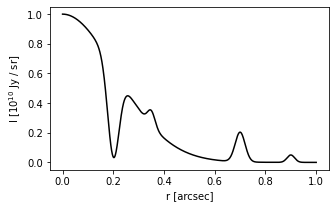

In [2]:
# make a brightness profile that's the sum of a background Gaussian envelope
# and multiple Gaussian gaps and rings

def gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def sigma(fwhm):
    "Provide a Gaussian's FWHM to return its standard deviation"
    return fwhm / (8 * np.sqrt(np.log(2)))

r = np.linspace(0, 1.0, 1000)

I = gauss(r, 1e10, 0.0, sigma(1.4)) - \
         gauss(r, 6e9, 0.2, sigma(0.15)) + \
         gauss(r, 1e9, 0.35, sigma(0.1)) + \
         gauss(r, 2e9, 0.7, sigma(0.13)) + \
         gauss(r, 5e8, 0.9, sigma(0.1))

plt.figure(figsize=(5,3))
plt.plot(r, I / 1e10, 'k')
plt.xlabel('r [arcsec]')
plt.ylabel(r'I $[10^{10}$ Jy / sr]');

Generate a synthetic, noisy visibility distribution using this profile and sampling the mock visibilitiess at the $(u,v)$ coordinates of the real DSHARP observations of AS 209.

In [3]:
# load the DSHARP AS 209 observations
as209_dat = np.load('AS209_continuum.npz')
u, v, vis, weights = [as209_dat[k] for k in ['u', 'v', 'V', 'weights']]

# create a frank geometry object that contains the published geometry values. 
# we'll use the inc and PA to deproject the (u, v) coordinates
geom = FixedGeometry(inc=34.97, PA=85.76, dRA=1.9e-3, dDec=2.5e-3)

In [4]:
# sample the mock profile at the deprojected data baselines.
# we'll generate the noiseless visibilities first, then add noise, 
# because we want the true visibility profile for later comparison 
# to the frank fits. Alternatively we could add noise straight away with 
# make_mock_data(r, I, Rmax=2.0, u=u, v=v, geometry=geom, 
#                add_noise=True, weights=weights)
baselines, V_noiseless = make_mock_data(r, I, Rmax=2.0, u=u, v=v, geometry=geom)

# add Gaussian noise according to the data weights
V_noisy = add_vis_noise(V_noiseless, weights, seed=47)

Fit the noisy mock data with the standard, non-negative and logaithmic `frank` models.

In [5]:
# choose frank hyperparameters
Rmax, N, alpha, weights_smooth = 2.5, 250, 1.01, 1e-1

In [6]:
# standard and non-negative fits: 

# initialize the FrankFitter class
FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth=weights_smooth)

# fit the data with the standard frank model
sol = FF.fit(u, v, V_noisy, weights)

# sample the visibility fit 
vis_fit = sol.predict_deprojected(sol.q).real

# get the non-negative fit 
I_nn = sol.solve_non_negative()

# sample the corresponding visibility fit 
vis_fit_nn = sol.predict_deprojected(sol.q, I_nn).real

In [7]:
# logarithmic fit: 

# initialize a new instance of the FrankFitter class
FF_log = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, 
                     weights_smooth=weights_smooth, method='LogNormal')

# fit the data with the logarithmic model 
sol_log = FF_log.fit(u, v, V_noisy, weights)

# sample the visibility fit 
vis_fit_log = sol_log.predict_deprojected(sol_log.q).real

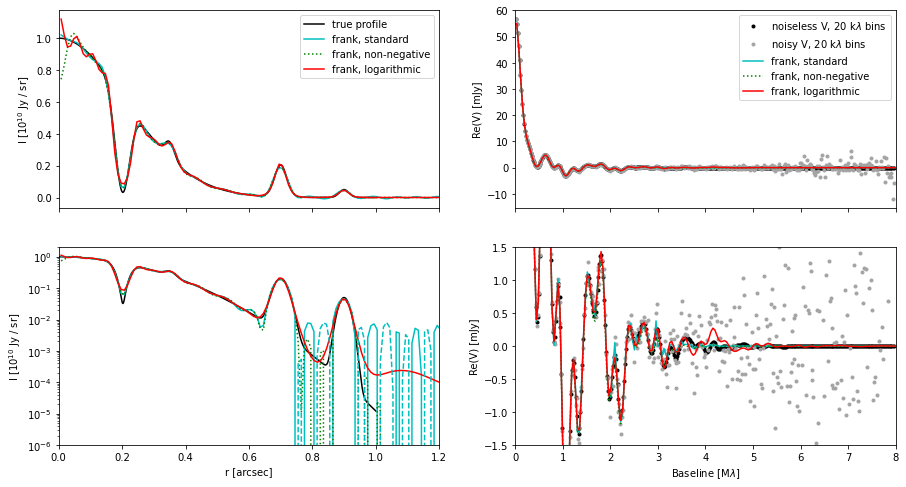

In [8]:
# bin the mock data (both the noiseless and noisy) and plot them, 
# along with each of the 3 frank fits

# bin size [lambda]
bin_width = 20e3

bin_noiseless = UVDataBinner(baselines, V_noiseless, weights=weights, bin_width=bin_width)
bin_noisy = UVDataBinner(baselines, V_noisy, weights=weights, bin_width=bin_width)

baselines_bin = bin_noiseless.uv
V_noiseless_bin = bin_noiseless.V
V_noisy_bin = bin_noisy.V
    
fig, axs = plt.subplots(2, 2, sharex='col', figsize=(15,8))

# brightness profile plots
for ax in [axs[0][0], axs[1][0]]:
    ax.plot(r, I / 1e10, 'k-', label='true profile')

    ax.plot(sol.r, sol.I / 1e10, 'c', label='frank, standard')
    ax.plot(sol.r, I_nn / 1e10, 'g:', label='frank, non-negative')
    ax.plot(sol_log.r, sol_log.I / 1e10, 'r', label='frank, logarithmic')

    ax.set_ylabel(r'I $[10^{10}$ Jy / sr]')
    ax.set_xlim(0,1.2)

axs[1][0].plot(sol.r, -sol.I / 1e10, 'c--')          

axs[0][0].legend()
axs[1][0].set_xlabel('r [arcsec]')
axs[1][0].set_yscale('log')
axs[1][0].set_ylim(1e-6,2)

# visibility plots
for ax in [axs[0][1], axs[1][1]]:
    ax.plot(baselines_bin / 1e6, V_noiseless_bin * 1e3, 'k.', 
            label='noiseless V, {:.0f} k$\lambda$ bins'.format(bin_width/1e3))  
    ax.plot(baselines_bin / 1e6, V_noisy_bin * 1e3, '.', c='#a4a4a4', 
            label='noisy V, {:.0f} k$\lambda$ bins'.format(bin_width/1e3))
    
    ax.plot(sol.q / 1e6, vis_fit * 1e3, 'c', label='frank, standard')
    ax.plot(sol.q / 1e6, vis_fit_nn * 1e3, 'g:', label='frank, non-negative')
    ax.plot(sol_log.q / 1e6, vis_fit_log * 1e3, 'r', label='frank, logarithmic')

    ax.set_ylabel('Re(V) [mJy]')
    ax.set_xlim(0,8)

axs[0][1].legend()    
axs[1][1].set_xlabel(r'Baseline [M$\lambda$]')
axs[1][1].set_ylim(-1.5, 1.5);

Comparing the standard, non-negative and logarithmic `frank` fits, in the brightness profiles of the upper-left panel (and lower-left, plotted in log brightness) we see they each have relative advantages and tradeoffs: 

1. The standard fit (along with the non-negative fit) most accurately recovers the deep gap at 200 mas, but it shows some shallow, fake oscillations at low brightness at $\approx$ 600 mas and beyond 750 mas, where the fit dithers between positive and negative (unphysical) values (in the lower-left panel, negative fit regions are dashed).

2. The non-negative fit by definition prevents these negative regions, but it shows worse error near $r=0$.

3. As is clear in the lower-left panel, the logarithmic fit more accurately traces the very low surface brightness in the true profile around 600 mas and beyond. It does slightly worse at recovering the gap depth at 200 mas.

In the upper-right panel, the visibility fits of the three models look nearly identical (they're almost on top of one another), and we're showing both the noiseless visibilities (corresponding to the true profile in the left panels) and the noisy visibilities that we fit. Zooming in to smaller visibility amplitudes in the lower-right panel, there is some difference between the logarithmic model and the standard/non-negative models (which are very similar) between $\approx 2.5 - 5.5\ {\rm M}\lambda$. The logarithmic fit shows more structure in this region, though that structure is not perfectly accurate (comparing it to the black points of the noiseless visibilities). None of the three models is uequivocally favored; the comparison between them is instead useful.

In general we can expect the logarithmic model to suppress noise in regions of faint surface brightness in a profile, as we saw in this case in the outer disk. It is not guarateed to _always_ be a better fit in faint regions; the true disk morphology and the quality of the observed visibility data both play a role.